In [1]:
import numpy as np
import torch
from utils_en.data_process import data_process
from utils_en.faster_rcnn import load_model

In [2]:
def create_model():
    test_loader = data_process(
        image_dir='../data/VOC2012/animal_images_test',
        annotation_dir='../data/VOC2012/animal_annotations_test',
    )
    # Get the paths to the test files

    model = load_model()
    device = torch.device('cpu')
    model.to(device)
    model.load_state_dict(torch.load('../model/model.pt', map_location=device))
    print("Completed loading model")
    # Load the model and set it to CPU mode

    return model, device, test_loader

In [3]:
def evaluate(outputs, targets, score_threshold=0.5):
    total_predicted = 0
    total_correct = 0
    animal_classes = [1, 2, 3, 4, 5, 6]
    # Define a list of indices for animal classes, excluding the background

    for output, target in zip(outputs, targets):
        pred_boxes = output['boxes'].cpu().numpy()
        pred_labels = output['labels'].cpu().numpy()
        pred_scores = output['scores'].cpu().numpy()
        # Convert the tensors of the test results to numpy arrays for easier processing

        high_conf_indices = pred_scores > score_threshold
        pred_boxes = pred_boxes[high_conf_indices]
        pred_labels = pred_labels[high_conf_indices]
        pred_scores = pred_scores[high_conf_indices]
        # Filter out predictions with scores below the threshold

        true_boxes = target['boxes'].cpu().numpy()
        true_labels = target['labels'].cpu().numpy()
        animal_indices = np.isin(true_labels, animal_classes)
        true_boxes = true_boxes[animal_indices]
        true_labels = true_labels[animal_indices]
        # Extract the true bounding boxes and labels, keeping only the ones that belong to animal classes

        print(f"Predicted boxes: {pred_boxes}, Predicted labels: {pred_labels}, Scores: {pred_scores}")
        print(f"True boxes: {true_boxes}, True labels: {true_labels}")

        total_predicted += len(pred_labels)
        total_correct += sum(pred == true for pred, true in zip(pred_labels, true_labels))
        # Calculate the number of predicted and true labels

    accuracy = total_correct / total_predicted
    print(f"Accuracy: {accuracy:.4f}")

In [4]:
def test(model, device, test_loader):
    model.eval()
    with torch.no_grad():
        # Set the model to evaluation mode and disable gradient computation

        for images, targets in test_loader:
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            # Move the data to the specified device

            outputs = model(images)
            evaluate(outputs, targets)
            # Get the evaluation results and call the evaluate function to calculate accuracy

In [5]:
from matplotlib import pyplot as plt

def generate_image(image_tensor, boxes, labels, scores, threshold=0.5):
    animal_classes = ['background', 'bird', 'cat', 'cow', 'dog', 'horse', 'sheep']

    image_np = image_tensor.permute(1, 2, 0).cpu().numpy()
    # Convert the tensor from (C, H, W) format to (H, W, C) format for matplotlib

    fig, ax = plt.subplots(1, figsize=(12, 9))
    ax.imshow(image_np)
    # Create a window with subplots of size 12x9 and display the image

    for box, label, score in zip(boxes, labels, scores):
        if score >= threshold:
            xmin, ymin, xmax, ymax = box
            # Unpack the bounding box if the prediction confidence is above the threshold

            rect = plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False, color='red', linewidth=2)
            ax.add_patch(rect)
            # Create a rectangle object and add it to the plot, with no fill and a 2-pixel border

            ax.text(xmin, ymin, f'{animal_classes[label]}: {score:.2f}', bbox=dict(facecolor='yellow', alpha=0.5),
                    fontsize=12, color='black')
            # Add text to the plot at the top-left corner of the bounding box
            # Show the class label and prediction confidence, with a yellow background and 50% transparency

    plt.axis('off')
    plt.show()
    # Turn off the axis and display the image

In [6]:
def image_show():
    model, device, test_loader = create_model()
    model.eval()
    with torch.no_grad():
        # Set the model to evaluation mode and disable gradient computation

        for images, _ in test_loader:
            images = list(image.to(device) for image in images)

            outputs = model(images)
            # Get the prediction results

            image_tensor = images[0]
            output = outputs[0]
            # Extract the first image and its prediction results

            boxes = output['boxes'].cpu().numpy()
            labels = output['labels'].cpu().numpy()
            scores = output['scores'].cpu().numpy()
            # Convert the results to numpy arrays

            generate_image(image_tensor, boxes, labels, scores)
            break
            # Pass the image and results to the generate_image function and break the loop after displaying one image

Completed loading model


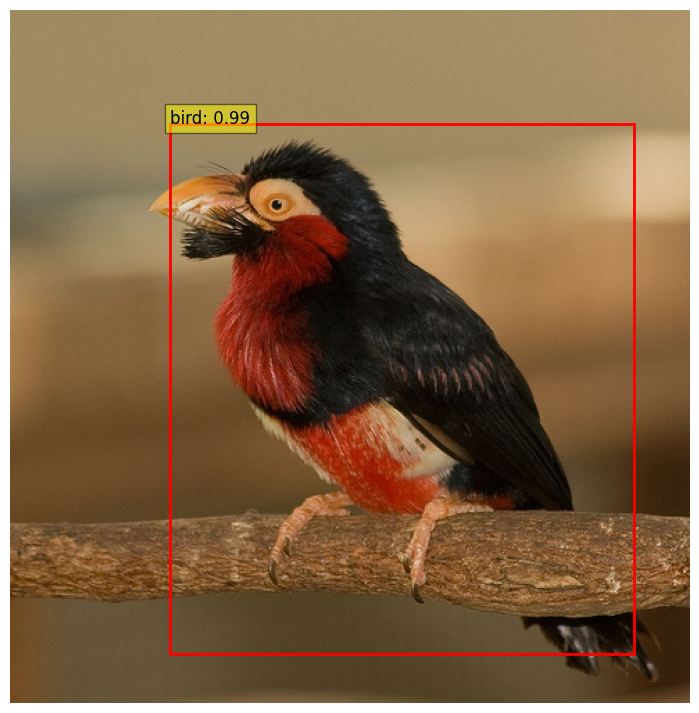

In [14]:
image_show()